- goal: build a term detector using spacy, improve it using prodigy

# 🪐 Spacy


In [19]:
!pip install networkx

In [34]:
!export CUDA_VISIBLE_DEVICES=1

In [2]:
# !python -m spacy download en_core_web_lg
import spacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy import displacy
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt


- let's run it out of the box:

In [4]:
g06t = open('G06T.txt').read().strip()
g06t_lines = g06t.split('\n')

print(len(g06t_lines), 'paragraphs of patent text')

patent_texts = g06t.split('\n\n')
patent_lines = g06t.split('\n')

nlp = spacy.load("en_core_web_lg")
shorttext = patent_texts[0][18000:20000]
# open('shorttext.txt','w').write(shorttext)
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)


298995 paragraphs of patent text


- graphically appealing but that's not exactly what we're looking for :)

- let's look at noun chunks:

In [5]:
for np in doc.noun_chunks:
    print(np.text)

r
receiver
The method
a variation
the widely known MPEG-DASH standard
(ISO/IEC
The available streams
the previous embodiments
The method
step
reception
subsequent presentation
a background data stream
The background data stream
information
information data
other information
the content
The background
the stream
the smallest bit rate
the set
available streams
a given content
it
it
delay
step
the method
reception
the foreground data stream
The stream
this step
step
it
it
the foreground data stream
delay
it
a predefined threshold delay
the method
the method
the possibility
the foreground data stream
step
the method
a blended foreground data stream
top
the background
reception
the original high bit rate stream
A skilled person
it
some quantitative quality
the connection
e.g. its speed
the reception
the high bit rate stream
it
the reception
it
the desired information
place
mere action
reception
the stream
the receiver device
the speed
the reception
The method
it
it
the original high bit rat

- let's visualize:

In [6]:
noun_chunks = [{
    'start': chunk.start_char,
    'end': chunk.end_char,
    'label': 'NC',
    'text': chunk.text
} 
    for chunk in doc.noun_chunks
]
funkycolor = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"
displacy.render({'text': shorttext, 'ents': noun_chunks, 'title': None},
                style='ent', options={'colors': {"NC": funkycolor}}, manual=True, jupyter=True)


- the system seems to get confused by the numbers in the text. let's remove them using our function from last time:

In [7]:
import re


def combineFreqDics(freq_dic):
    """
    function that combines entries of the freq_dic if they only differ in case into the most frequent case version
    """
    combined_dict = {}

    for key, value in freq_dic.items():
        normalized_key = key.lower()
        if normalized_key not in combined_dict:
            combined_dict[normalized_key] = (key, value)
        else:
            orig_key, orig_value = combined_dict[normalized_key]
            combined_dict[normalized_key] = (
                key if value > orig_value else orig_key, orig_value + value)

    return {key: value for key, value in combined_dict.values()}


def is_plural(singular, plural):
    return singular + 's' == plural or singular == plural + 's'


def rawExtractRefs(text, allnums=True, multipleResults=True):
    """
    text: the text potentially containing reference numerals
    NO: termjson: json as send back to the frontend
    allnums: if true also terms without parentheses
    """
    if allnums:
        renum = re.compile(r'[ (]\d+[) .,]')
    else:
        renum = re.compile(r'\(\d+\)')
    num2term = {}
    # print(111,'a\ba',222,r'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split()),333,'\b'+'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split())+r'\b')
    excluders = '''the a an 
    to for of under behind above least on which and or more all 
    Claim Claims Figure Figures Fig Figs'''
    noterms = re.compile(r'\b'+r'\b|\b'.join((excluders +
                         ' \W*\d+\W* \W*[,."()]+\W*').split())+r'\b'+r'|\W*[:;,?*%$=+()]+\W*', re.I)
    for m in renum.finditer(text):  # all number mathes
        i = int(m.group(0)[1:-1])

        potwords = text[0:m.start(0)].split()[-4:]
        # print(222,potwords)
        for j in range(len(potwords)):
            tu = ' '.join(potwords[j:])
            if not noterms.search(tu):
                num2term[i] = num2term.get(i, {})
                num2term[i][tu] = num2term[i].get(tu, 0)+1
        # print(333, [tuple(potwords[j:]) for j in range(len(potwords))], i)
    # print(444, num2term)
    num2termlist = {}
    for num, td in num2term.items():
        ctd = combineFreqDics(td)
        # print("555 ctd:",ctd)
        ma = max(ctd.values())
        mas = [(k, v) for k, v in ctd.items() if v == ma]
        # print('mas',mas)
        filtered_list = []
        for t, j in mas:
            add_to_list = True
            for s, i in mas:
                # is subset the right thing here?
                if t != s and set(t).issubset(set(s)):
                    add_to_list = False
                    break
            if add_to_list:
                filtered_list.append(t)
                # Check for less frequent terms that just differ in number
                for key, value in ctd.items():
                    if is_plural(t, key) and key not in filtered_list:
                        filtered_list.append(key)
                    elif is_plural(key, t) and t not in filtered_list:
                        filtered_list.append(t)

        # print('--->',filtered_list)
        num2termlist[num] = filtered_list
    return num2termlist


num2termlist = rawExtractRefs(shorttext)
display(num2termlist)

def removeNumbers(text, num2termlist):
    terms = [val for sublist in num2termlist.values() for val in sublist]
    numterms = re.compile(r'(\b'+r'\b|\b'.join(terms) +
                          r'\b) *[ (]\d+([) ]|([.,:]*)) *()', re.I)
    clean_text = numterms.sub(r'\1\3 ',text)
    return clean_text


cleanNshort = removeNumbers(shorttext, num2termlist)
print(cleanNshort)


{400: ['method'],
 401: ['begins at step'],
 102: ['background data stream'],
 402: ['step'],
 101: ['foreground data stream'],
 403: ['step'],
 404: ['step'],
 100: ['high bit rate stream'],
 406: ['step']}

r and receiver. The method is a variation of the widely known MPEG-DASH standard (ISO/IEC 23009-1:2012). The available streams are assumed to be prepared according to the previous embodiments.
The method begins at step with reception for subsequent presentation of a background data stream .
The background data stream may be retrieved based on information present in said blending information data or be retrieved based on other information available in the content.
The background (102) is the stream with the smallest bit rate (within the set of available streams for a given content) and therefore it is most probable that it will be received and presented without delay. Next, at step the method starts reception of the foreground data stream . The stream is not presented at this step. If, at step , it is verified whether it is possible to receive and present the foreground data stream without delay (or otherwise whether it is possible within a predefined threshold delay), the method moves 

In [8]:
doc = nlp(cleanNshort)

noun_chunks = [{
    'start': chunk.start_char,
    'end': chunk.end_char,
    'label': 'NC',
    'text': chunk.text
}
    for chunk in doc.noun_chunks
]
displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)
				



- let's improve this by removing the determiners:

In [9]:
def get_noun_chunks(doc):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        # Remove determiners from the noun chunk
        chunk_text = ' '.join([token.text for i, token in enumerate(
            chunk) if not (i == 0 and token.pos_ == 'DET')])

        # Get the start and end character positions of the modified noun chunk
        start_char = doc[chunk.start].idx if doc[chunk.start].pos_ != 'DET' else doc[chunk.start].nbor(
        ).idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })
    return noun_chunks


noun_chunks = get_noun_chunks(doc)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)


In [10]:
def get_noun_chunks(doc, remove_list=[], exclude_list=[]):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        exclude_list += ['that', 'which']
        if any(token.text in exclude_list for token in chunk):
            continue

        filtered_tokens = [
            token for token in chunk
            if token.dep_ != "relcl" and token.text not in remove_list and token.pos_ != 'DET' and not token.is_punct
        ]

        if not filtered_tokens:
            continue

        chunk_text = ' '.join(token.text for token in filtered_tokens)
        chunk_text = chunk_text.replace('"', '').replace("'", "")

        start_char = filtered_tokens[0].idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })

    return noun_chunks


remove_list = ['said', 'simply']
exclude_list = ['FIG', 'FIGS']

noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)




### adding the predicates

In [11]:
def get_predicates_between_noun_chunks(doc, noun_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(noun_chunks) - 1):
        start_chunk_token = doc.char_span(
            noun_chunks[i]['start'], noun_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            noun_chunks[i + 1]['start'], noun_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
        # print(
        #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets


text = "The model that is presented in FIGS 1 and 2 shows a data center configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."
# text = "the said data center cooling configuration that is included in the model."
doc = nlp(text)
displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

displacy.render({'text': text, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})


### a representation of the semantic graph

inspired by https://www.kaggle.com/code/cananserper/knowledge-graph-spacy  

In [12]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df

source                     target         edge
0                      model  data center configuration        shows
1  data center configuration   chilled water system app      include
2   chilled water system app                        ice         with
3                        ice               strawberries      include
4               strawberries   chilled water system app        choke
5   chilled water system app                      model  included in

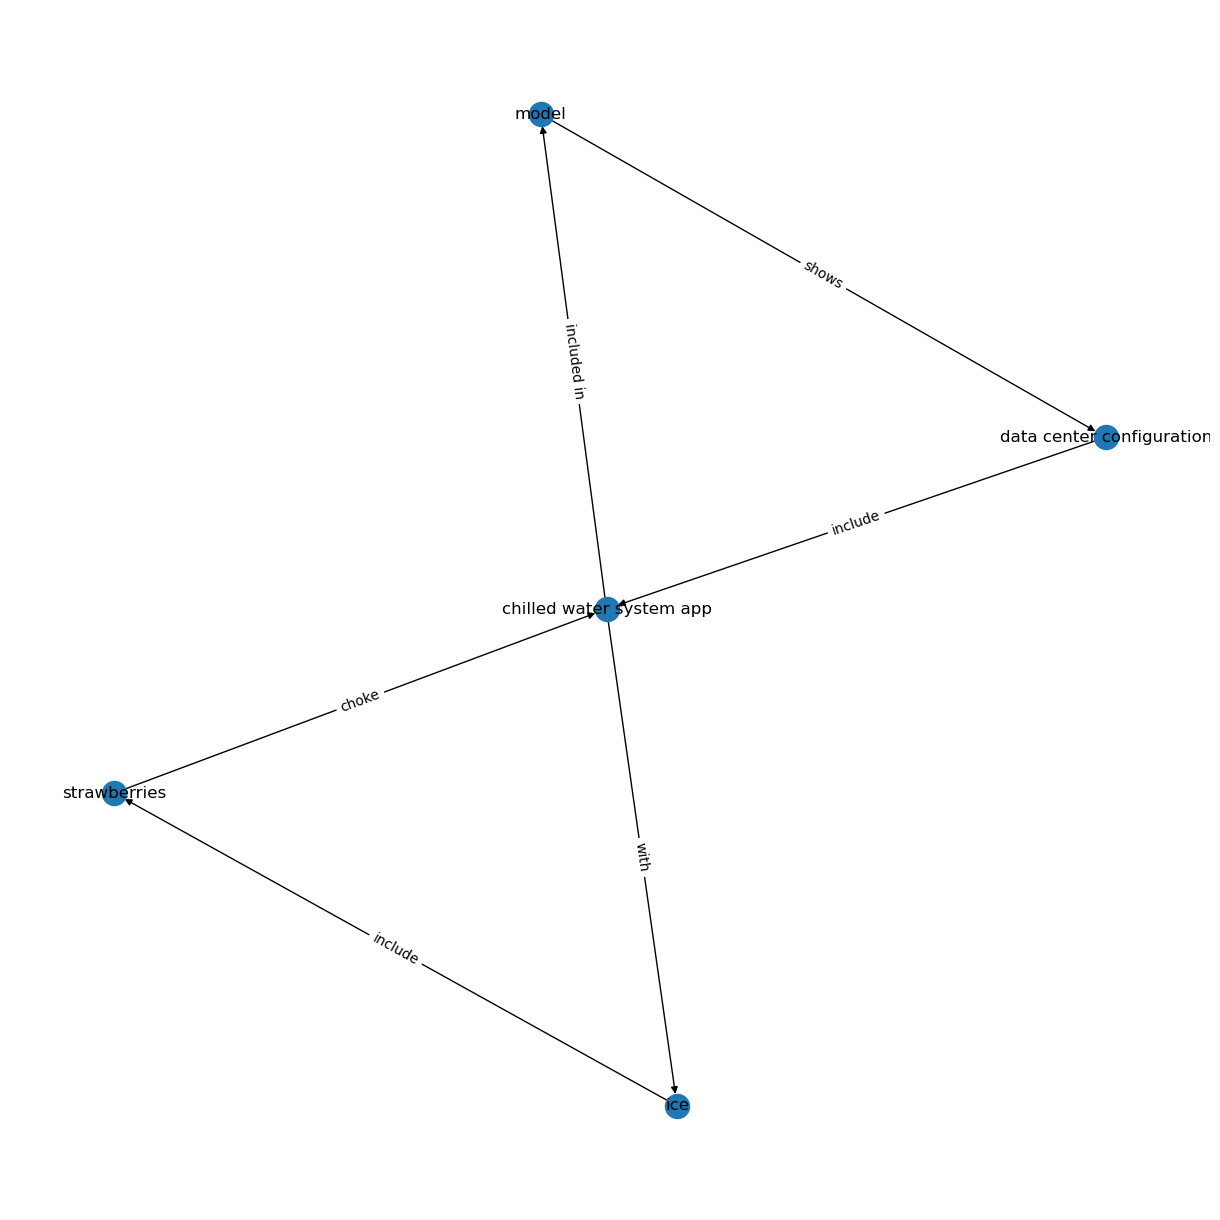

In [13]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [14]:
print(cleanNshort)
doc=nlp(cleanNshort)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})


r and receiver. The method is a variation of the widely known MPEG-DASH standard (ISO/IEC 23009-1:2012). The available streams are assumed to be prepared according to the previous embodiments.
The method begins at step with reception for subsequent presentation of a background data stream .
The background data stream may be retrieved based on information present in said blending information data or be retrieved based on other information available in the content.
The background (102) is the stream with the smallest bit rate (within the set of available streams for a given content) and therefore it is most probable that it will be received and presented without delay. Next, at step the method starts reception of the foreground data stream . The stream is not presented at this step. If, at step , it is verified whether it is possible to receive and present the foreground data stream without delay (or otherwise whether it is possible within a predefined threshold delay), the method moves 

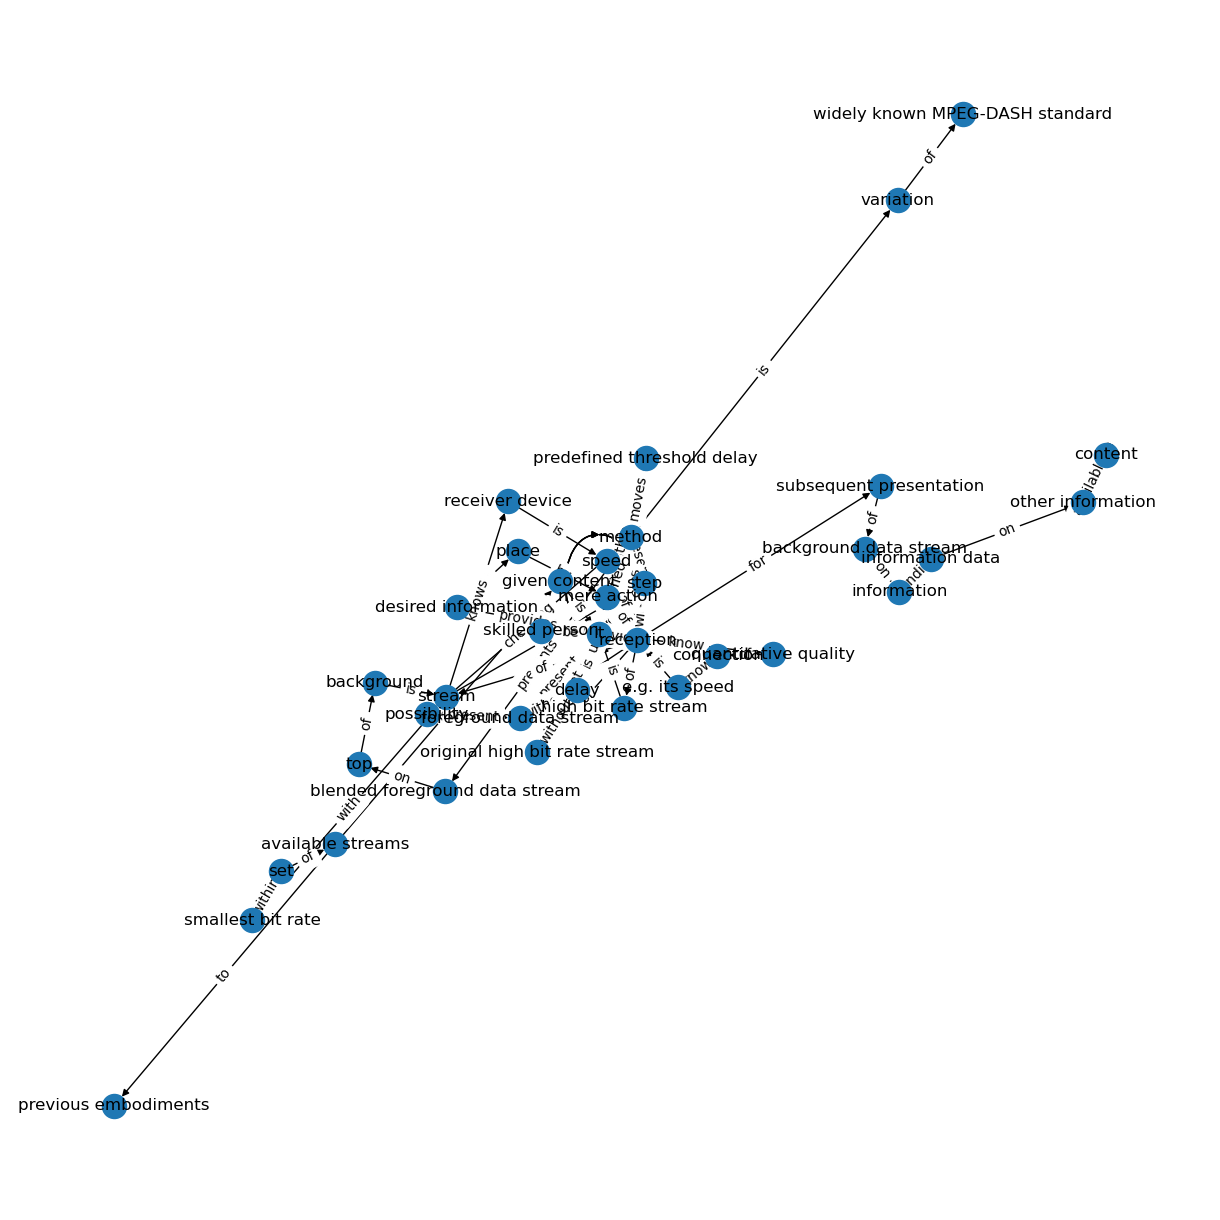

In [15]:
df = pd.DataFrame({'source': [str(s) for s in sources], 
                    'target': [str(t) for t in targets], 
                    'edge': [r['text'] for r in predicates]})

G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


#### find errors

#### ideas
- make a matrix of relations between all NC in a sentence and choose the best ones
- handle coordinations
- ternary relations work?
- better parser: Trankit?
- text preparation to improve results
	- "said"
	- past participles into "that is pp" (no past tense in patents?)
- coreference resolution
- negation
- special treatment for non-connected graphs
- nice inline visualization



### work with Prodigy

goal
- train spacy models for the extraction of relations
- find alternative
- compare

https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893

In [16]:
import re, regex, timeit, gzip, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from nltk.tokenize import MWETokenizer
from nltk.util import Trie
import pandas as pd
# if restarting here: (17 secs)
from spacy.matcher import PhraseMatcher
tqdm.pandas()

In [17]:
g06t_lines = g06t.split('\n')
print(len(g06t_lines),'lines of patent text')
cvectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', min_df=500) # , stop_words='english'  max_features
X=cvectorizer.fit_transform(g06t_lines)
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out()).T.sort_values(by = 0, ascending = False)


298995 lines of patent text


In [18]:
# Get the top-10 most frequent terms
freq_terms_df = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out(
)).T.sort_values(by=0, ascending=False)
freq_terms_df.head(10)

0
image data            27634
image processing      20995
present invention     17756
according embodiment  14986
present disclosure    14878
electronic device     11964
processing unit       11779
embodiment present    11362
shown fig             10331
control unit           9676

In [19]:
nlp = spacy.load("en_core_web_lg")
doc = nlp(patent_texts[0][18000:20000])
displacy.render(doc, style="ent", jupyter=True)

In [20]:
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in freq_terms_df.index]
matcher.add("TT", patterns)

In [21]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(patent_lines, test_size=0.3, random_state=42)

In [22]:
def Dataset(split, dataset):
    LABEL = "TT"
    doc_bin = DocBin() # create a DocBin object
    nlp = spacy.blank("en")
    # nlp.max_length = 2000000
    for training_example  in tqdm(dataset): #~5 patents
        doc = nlp.make_doc(training_example) 
        ents = []

        for match_id, start, end in matcher(doc):
            #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
            span = Span(doc, start, end, label=LABEL)
            print(span, span.label_)
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)

        filtered_ents = filter_spans(ents)
        #print(filtered_ents[:3])
        doc.ents = filtered_ents 
        doc_bin.add(doc)
    doc_bin.to_disk("{}_data.spacy".format(split))
    return doc_bin

In [23]:
doc_bin_train = Dataset('train',train_lines[:30000])
doc_bin_val = Dataset('val', test_lines[:10000])
doc_bin_test = Dataset('test', test_lines[10000:12000])


  0%|          | 0/30000 [00:00<?, ?it/s]

imaging data TT
image acquisition TT
performed using TT
control section TT
Central Processing TT
Central Processing Unit TT
Processing Unit TT
Random Access TT
Random Access Memory TT
Access Memory TT
Central Processing TT
Central Processing Unit TT
Processing Unit TT
Random Access TT
Random Access Memory TT
Access Memory TT
information regarding TT
BRIEF DESCRIPTION TT
device according TT
present invention TT
image sensor TT
present disclosure TT
block diagram TT
point cloud TT
point cloud data TT
cloud data TT
present disclosure TT
computing device TT
image acquiring TT
point cloud TT
data acquired TT
graphics processing TT
graphics processing TT
dimensional data TT
diagram showing TT
showing example TT
diagram showing TT
example shown TT
hereinafter referred TT
ultrasound image TT
image data TT
ultrasound image TT
image data TT
3D model TT
3D model TT
image data TT
3D model TT
image data TT
ultrasound image TT
image data TT
ultrasound image TT
image data TT
present invention TT
seco

  0%|          | 0/10000 [00:00<?, ?it/s]

images generated TT
medical image TT
dimensional data TT
processing performed TT
horizontal direction TT
vertical direction TT
image obtained TT
processing performed TT
horizontal direction TT
vertical direction TT
processing performed TT
present disclosure TT
second image TT
second image TT
apparatus according TT
generation unit TT
determination unit TT
image includes TT
input unit TT
determination result TT
composite image TT
composite image TT
information indicating TT
TECHNICAL FIELD TT
period time TT
threshold value TT
threshold value TT
communication network TT
communication network TT
display method TT
method according TT
information includes TT
digital image TT
image comprises TT
data storage TT
digital image TT
data storage TT
image processing TT
digital image TT
image processing TT
digital image TT
image obtained TT
mobile terminal TT
information including TT
mobile device TT
data representing TT
light image TT
3D image TT
light image TT
2D image TT
3D image TT
2D image TT
im

  0%|          | 0/2000 [00:00<?, ?it/s]

Background Art TT
graphics processing TT
image region TT
images captured TT
user interface TT
determined based TT
input data TT
input data TT
input data TT
input data TT
processing unit TT
processing unit TT
processing units TT
processing units TT
processing units TT
information processing TT
information processing device TT
processing device TT
processing device according TT
device according TT
present disclosure TT
diagram illustrating TT
information processing TT
information processing device TT
processing device TT
processing device according TT
device according TT
present disclosure TT
analysis apparatus TT
apparatus according TT
present invention TT
raw image TT
raw image TT
image processing TT
image processing TT
image processing TT
processing section TT
image processing TT
raw image TT
image based TT
image processing TT
image processing TT
image processing TT
processing section TT
block diagram TT
information processing TT
example illustrated TT
information processing TT
embodi

In [24]:
# takes some time!
# if it crashes VS Code you may want to try to run this line directly in the command line
!python -m spacy train config.cfg --output ./spacy_output_img --paths.train ./train_data.spacy --paths.dev ./val_data.spacy

ℹ Saving to output directory: spacy_output_img
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
[2023-04-24 00:45:12,820] [INFO] Set up nlp object from config
[2023-04-24 00:45:12,832] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-04-24 00:45:12,835] [INFO] Created vocabulary
[2023-04-24 00:45:14,498] [INFO] Added vectors: en_core_web_lg
[2023-04-24 00:45:16,468] [INFO] Finished initializing nlp object
[2023-04-24 00:45:50,358] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     50.50    0.23    0.41    0.16    0.00
  0     200          6.70   1665.16   49.13   67.01   38.

In [47]:
# Load best model
nlp_ner = spacy.load("./spacy_output/model-best")

# Just text snippet
doc = nlp_ner("Web scraping or web data extraction methods are known in the art. Web scraping is used to access the World Wide Web directly using the Hypertext Transfer Protocol, or through a web browser. Web scraping typically refers to automated processes implemented using a bot or web crawler. It is a form of copying, in which specific data is gathered and copied from the web, typically into a central local database or spreadsheet, for later retrieval or analysis.\
Web scraping a web page involves retrieving a predefined Hypertext Markup Language (HTML) page and extracting data from it. Fetching is the downloading of a page which is stored under a static Web address typically specified by a Uniform Resource Locator (URL). Once the page is fetched from where it had been stored, extraction can take place. The content of a page may then be parsed, searched, reformatted, etc. Web scrapers typically extract certain parts of a page to make use \
of it for another purpose. An example is to find and copy names and phone numbers, \
or companies and their URLs, to a list (so-called contact scraping).\
Prior art Web scraping tools can retrieve web page content from pages which are stored as predefined HTML data. Such content is referred to as static content herein because it relates to content provided by static web pages. However, current web technology allows to dynamically generate web pages on a web server in response to requests which may be received from a user or a computer system. As a consequence, data shown on websites can continuously change. A web page containing respective data can change \
its layout and new data fields may be introduced at any time. The content of such dynamic web pages (dynamic content) typically depends on the navigation history through a website. In other words, it depends on where the user currently is and which information and requests have been sent previously.\
 Current Web scraping tools fail to scrape dynamic content data from such dynamically generated web pages and provide respective content data in a machine-readable format so that the content can be further processed by other computer systems provided with the extracted data.\
Summary\
Hence, there is a need for providing improved methods and systems to enable web scraping for dynamic content on dynamic web pages. \
This technical problem is solved by a computer system, a computer-implemented method and a computer program product as disclosed in the independent claims. The disclosed embodiments define a screen-scraping framework which addresses the above problem by automatically connecting to a target website and extracting dynamic data from said target website.\
")

# Show NER results
spacy.displacy.render(doc, style="ent", jupyter=True)